In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:

import cv2
import numpy as np

def detect_lines(img, threshold1=200, threshold2=300, apertureSize=5, minLineLength=600, maxLineGap= 50):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1, threshold2, apertureSize=apertureSize)
    lines = cv2.HoughLinesP(
                edges,
                10,
                np.pi/180,
                300,
                minLineLength=minLineLength,
                maxLineGap=maxLineGap,
        ) # detect lines

    return lines

def draw_lines(img, lines, color=(0, 255, 0)):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
    return img

def get_slopes_intercepts(lines):
    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 != 0:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
        else:
            slope = None  # Vertical line case
            intercept = None
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

def detect_lanes(lines, slope_threshold=0.05, intercept_threshold=1):
    slopes, intercepts = get_slopes_intercepts(lines)
    lanes = []
    used_lines = set()  # Keep track of lines that have been assigned to a lane

    for i in range(len(lines)):
        if i in used_lines:
            continue  # Skip lines that have already been assigned to a lane

        best_pair = None
        best_intercept_diff = float('inf')

        for j in range(i + 1, len(lines)):
            if j in used_lines:
                continue  # Skip lines that have already been assigned to a lane

            if slopes[i] is not None and slopes[j] is not None:
                slope_diff = abs(slopes[i] - slopes[j])
                intercept_diff = abs(intercepts[i] - intercepts[j])

                if slope_diff < slope_threshold and intercept_diff > intercept_threshold:
                    if intercept_diff < best_intercept_diff:
                        best_intercept_diff = intercept_diff
                        best_pair = j

        if best_pair is not None:
            lanes.append([lines[i], lines[best_pair]])
            used_lines.add(i)
            used_lines.add(best_pair)

    return lanes

def draw_lanes(img, lanes):
    colors = [[0, 255, 0],[255,0,0], [0,0,255], [255,255,255], [0,0,0]]
    for i, lane in enumerate(lanes):
        color = colors[i%5]
        for line in lane:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), color, 2)
    return img



In [37]:
import cv2 
import numpy as np
def get_slopes_intercepts(lines):
    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 != 0:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
        else:
            slope = None  # Vertical line case
            intercept = None
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

def get_lane_center(lanes, img_width):
    if not lanes:
        return None, None
    
    # Initialize the closest lane variables
    closest_distance = float('inf')
    closest_intercept = None
    closest_slope = None

    # Image center
    img_center_x = img_width // 2

    # Compute center of each lane and find the closest
    for lane in lanes:
        for line in lane:
            slopes, intercepts = get_slopes_intercepts([line])
            distance = abs(img_center_x - intercepts[0])
            
            if distance < closest_distance:
                closest_distance = distance
                closest_slope = slopes[0]
                closest_intercept = intercepts[0]

    return  closest_slope, closest_intercept

def recommend_direction(slope, center_intercept, img_width):
    if center_intercept is None or slope is None:
        return "unknown"
    
    # Image center
    img_center_x = img_width // 2

    # Determine the position of the lane center
    if center_intercept is not None:
        if center_intercept < img_center_x - 50:  # Adjust threshold as needed
            return "left"
        elif center_intercept > img_center_x + 50:  # Adjust threshold as needed
            return "right"
        else:
            return "forward"
    else:
        return "unknown"


24
9
left


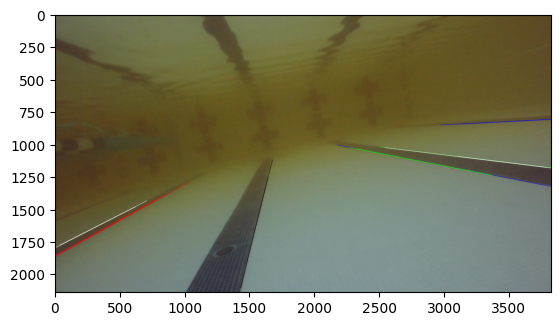

In [45]:
img = cv2.imread('/home/aidan/cv-intro/why.jpg', 1)
lines = detect_lines(img)
print(len(lines))
#img = draw_lines(img, lines)
#plt.imshow(img)
slopes, intercepts = get_slopes_intercepts(lines)
lanes = detect_lanes(lines)
print(len(lanes))
img = draw_lanes(img, lanes)
plt.imshow(img)
closeslope, closeintercept = get_lane_center(lanes, np.shape(img)[1])
print(recommend_direction(closeslope, closeintercept, np.shape(img)[1]))